# Project 1 - Microlensing 1
# Brandon Shane, Ina Park, Toshan Vysyraju, Arya Lakshmanan

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

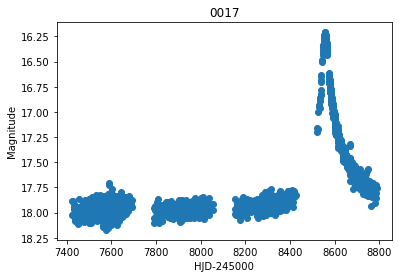

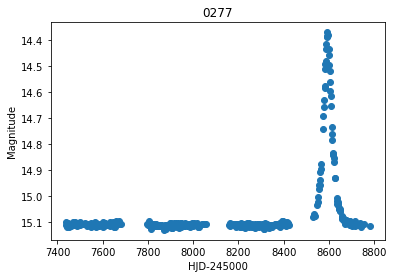

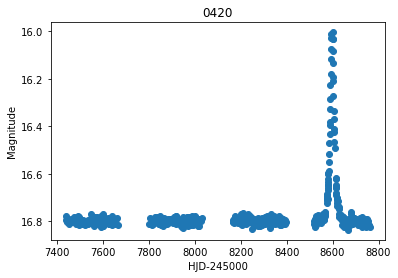

In [2]:
# _locs = ['OGLE-2019-BLG-/blg-0017/',]
data = {}
names = ['0017','0277','0420']

for name in names:
    d = np.loadtxt('OGLE-2019-BLG-'+name+'/blg-'+name+'/phot.dat', dtype=float)
    x = d[:,0] - 245e4
    y = d[:,1]
    
    plt.scatter(x,y)
    plt.gca().invert_yaxis()
    plt.title(name)
    plt.xlabel('HJD-245000')
    plt.ylabel('Magnitude')
    plt.show()

    
    data[name] = d
    


In [3]:
def xi(param):
    'X^2 to mininize to find parameters'
    #m_bl being the baseline magnitude
    umin,tE, m_bl, t_0 = param 
    
    u = np.sqrt(umin**2 + ((x-t_0)/tE)**2)
    A = u**2 + 2
    A /= (u*np.sqrt((u**2)+4))
    #m_mod refers to m observed as predicted by our model 
    m_mod = m_bl - 2.5*np.log10(A)
    
    
    tot = 0
    for i in range(len(y)):
        tot += ((y[i] - m_mod[i])**2)/s[i]**2 
    return tot

Optimization terminated successfully.
         Current function value: 64760.065746
         Iterations: 423
         Function evaluations: 718


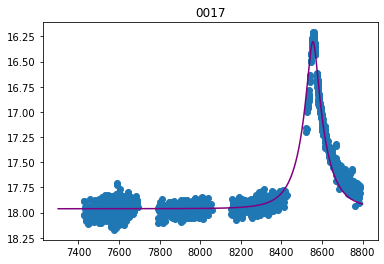

Optimization terminated successfully.
         Current function value: 1894.523544
         Iterations: 413
         Function evaluations: 713


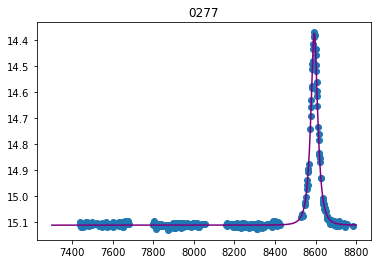

Optimization terminated successfully.
         Current function value: 1172.420696
         Iterations: 444
         Function evaluations: 753


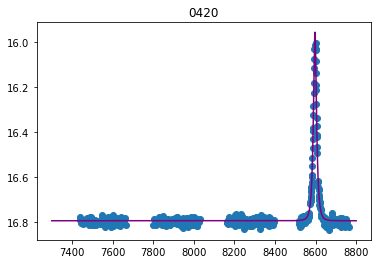

In [4]:
for name in data.keys():
    d = data[name]
    x = d[:,0] - 245e4
    y = d[:,1]
    s = d[:,2]
    
    
    # Might want to plot error barrs in scatterplot
    plt.scatter(x,y)
    # f_src_guess = np.nanmean(y[(x>7400) & (x<8400)])
    #plt.axhline(y=f_src_guess)
    
    f_src_guess = np.nanmean(y[(x>7400) & (x<8000)])
    
    opt = optimize.fmin(xi,[0.1,1000,f_src_guess, x[y==np.max(y)]])
    opt = np.array(opt)

    xlist = np.linspace(7300, 8800, 1000)
    #umin,tE, m_bl, t_0 = [0.036, 421, 17.99, 8600]
    umin,tE, m_bl, t_0 = opt

    u=[]
    A=[]
    m_mod=[]
    for i in range(len(xlist)):
        u.append(np.sqrt(umin**2 + ((xlist[i]-t_0)/tE)**2))
        A.append((u[i]**2 + 2)/(u[i]*np.sqrt((u[i]**2)+4)))
        m_mod.append(m_bl - 2.5*np.log10(A[i]))
    plt.gca().invert_yaxis()

    # A 

    plt.plot(xlist,m_mod,color='purple')
    plt.title(name)
    plt.show()